# Phân tích tai nạn giao thông tại UK (2014 - 2019)

In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Run decision tree
import sklearn
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn.ensemble import RandomForestClassifier # random forest
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier # random forest ver xịn
from sklearn.model_selection import train_test_split # Import train_test_split function
from sklearn import metrics # Import scikit-learn metrics module for accuracy calculation
from sklearn import preprocessing # Add num label for categorical variable
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix # kiểm định model

# select model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# kiểm định thống kê
import math
from scipy.stats import chi2_contingency

# remove warnings
import warnings
warnings.simplefilter('ignore')

# save models
import joblib
try:
    os.mkdir('./pretrained')
except:
    pass

In [3]:
df = pd.read_csv('../Data/afterPreprocess.csv')
df.head(2)

Grid Ref: Easting  Grid Ref: Northing Number of Vehicles Accident Date  \
0             429427              433921                  2    2014-01-01   
1             430481              433453                  1    2014-01-01   

  Time (24hr) 1st Road Class Road Surface  \
0    14:15:00           A(M)          Dry   
1    00:05:00   Unclassified          Dry   

                       Lighting Conditions       Weather Conditions  \
0          Daylight: Street lights present  Fine without high winds   
1  Darkness: Street lights present and lit  Fine without high winds   

  Type of Vehicle Casualty Class Casualty Severity Sex of Casualty  \
0             Car      Passenger            Slight            Male   
1             Car      Passenger            Slight            Male   

   Age of Casualty  
0               28  
1               29

## Phân tích mô tả

### Hàm bổ trợ

In [4]:
# tạo trục ox
def makeXAxis(start, step, end):
  x_axis = []
  pre = start
  while True:
    next = pre + step
    if next > end:
      next = end
    x_axis.append((pre, next))
    pre += step
    if pre >= end:
      break
  return x_axis

# tạo trục oy
def makeYAxis(s, x_axis):
  y_axis_values = {}
  for i in x_axis:
    y_axis_values[i] = []

  for i in s:
    for j in x_axis:
      if j[1] == x_axis[-1][1]:
        if i >= j[0] and i <= j[1]:
          y_axis_values[j].append(i)
      elif i >= j[0] and i < j[1]:
        y_axis_values[j].append(i)

  y_axis = []
  for i in x_axis:
    y_axis.append(len(y_axis_values[i]))
  return y_axis

# vẽ bar chart
def draw(x_axis, y_axis, title, x_label, y_label, size, rotation=45, barh=False):
  plt.figure(figsize=size)
  plt.xticks(rotation = rotation)
  if barh:
      plt.barh([str(i) for i in x_axis], y_axis, zorder=3)
      plt.grid(b=True, axis='x', zorder=0)
  else:
      plt.bar([str(i) for i in x_axis], y_axis, zorder=3)
      plt.grid(b=True, axis='y', zorder=0)
  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)
  plt.show()

In [5]:
# đổi grid -> latitude, longitude
# tham khảo: https://scipython.com/book/chapter-2-the-core-python-language-i/additional-problems/converting-between-an-os-grid-reference-and-longitudelatitude/

def scale_lat_coord(phi, F0=0.9996012717, a=6377563.396, b=6356256.909, phi0=math.radians(49)):
    n = (a - b) / (a + b)
    n2 = n ** 2; n3 = n ** 3
    dphi, sphi = phi - phi0, phi + phi0
    
    return (b * F0) * ((1 + n + (5/4)*(n2+n3)) * dphi
                      - ((3*n + 3*n2 + (21/8)*(n3)) * math.sin(dphi) * math.cos(sphi))
                      + (((15/8)*(n2) + (15/8)*(n3)) * math.sin(2*dphi) * math.cos(2*sphi))
                      - ((35/24)*(n3) * math.sin(3*dphi) * math.cos(3*sphi))
                      )
    
def grid_to_ll(grid, a=6377563.396, b=6356256.909, N0=-100000, F0=0.9996012717, lambda0=math.radians(-2), E0=400000):
    M = phip = 0
    e2 = (a**2 - b**2) / (a**2)
    
    while abs(grid[1] - N0 - M) >= 1e-5:
        phip += (grid[1] - N0 - M) / (a * F0)
        M = scale_lat_coord(phip)
        
    sin_phip2 = math.sin(phip)**2
    nu = (a * F0) / math.sqrt(1 - e2 * sin_phip2)
    rho = (a * F0) / ((1 - e2) / (1 - e2*sin_phip2)**(3/2))
    eta2 = (nu / rho) - 1
    
    tan_phip = math.tan(phip); tan_phip2 = tan_phip**2
    sec_phip = 1 / math.cos(phip)
    
    c1 = tan_phip / (2*rho*nu)
    c2 = tan_phip / (24*rho*nu**3) * (5 + (3 - 9*eta2)*tan_phip2 + eta2)
    c3 = tan_phip / (720*rho*nu**5) * (61 + (90 + 45*tan_phip2)*tan_phip2)
    
    d1 = sec_phip / nu
    d2 = sec_phip / (6*nu**3) * ((nu / rho) + 2*tan_phip2)
    d3 = sec_phip / (120*nu**5) * (5 + (28 + 24*tan_phip2)*tan_phip2)
    d4 = sec_phip / (5040*nu**7) * (61 + (662 + (1320 + 720*tan_phip2)*tan_phip2)*tan_phip2)
    
    e_e0 = grid[0] - E0; e_e0_2 = e_e0**2
    phi = phip - (c1 + (c2 - c3*e_e0_2)*e_e0_2)*e_e0_2
    lamb = lambda0 + (d1 + (-d2 + (d3 - d4*e_e0_2)*e_e0_2)*e_e0_2)*e_e0
    
    return (math.degrees(phi), math.degrees(lamb))

### **Loại phương tiện gây tai nạn nhiều nhất**
- Thống kê các loại xe gây tai nạn cho thấy xe hơi là loại xe gây tai nạn phổ biến nhất
- Theo sau đó là xe đạp, xe bus 17 chỗ, taxi, các loại xe moto

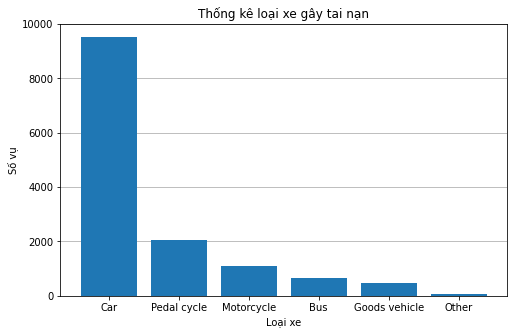

In [6]:
typeVehicle = df['Type of Vehicle'].value_counts()
draw(typeVehicle.index, typeVehicle.values, y_label='Số vụ', x_label='Loại xe', title='Thống kê loại xe gây tai nạn', rotation=0, size=(8,5))

### **Kiểu thời tiết phổ biến khi xảy ra tai nạn**
- Khi xảy ra tai nạn, kiểu thời tiết "Thời tiết tốt và không có gió to" là phổ biến nhất
- Tiếp theo đó là các loại thời tiết: "Trời mưa không gió", "Trời mưa và có gió to", không xác định

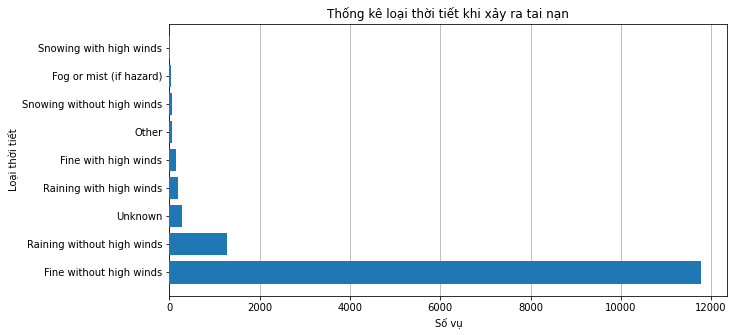

In [7]:
weatherCond = df['Weather Conditions'].value_counts()
draw(weatherCond.index, weatherCond.values, y_label='Loại thời tiết', x_label='Số vụ', title='Thống kê loại thời tiết khi xảy ra tai nạn', rotation=0, barh=True, size=(10,5))

### **Điều kiện mặt đường khi xảy ra tai nạn**

- Các vụ tai nạn thường xảy ra khi mặt đường ở trạng thái khô ráo hoặc ẩm ướt

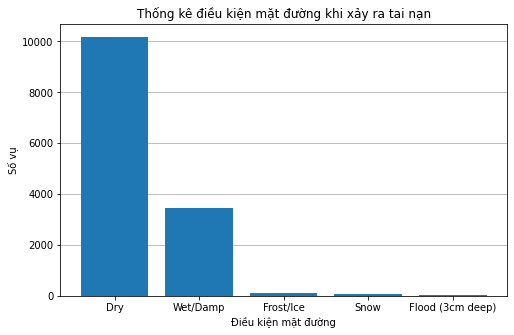

In [8]:
roadCond = df['Road Surface'].value_counts()
draw(roadCond.index, roadCond.values, y_label='Số vụ', x_label='Điều kiện mặt đường', title='Thống kê điều kiện mặt đường khi xảy ra tai nạn', rotation=0, size=(8,5))

### **Đối tượng gặp tai nạn**

- Phần lớn đối tượng bị/gây tai nạn là người điều khiển phương tiện giao thông.
- Tiếp theo đó là người đi cùng và người đi bộ

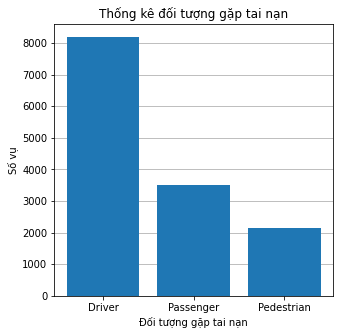

In [9]:
casualtyClass = df['Casualty Class'].value_counts()
draw(casualtyClass.index, casualtyClass.values, y_label='Số vụ', x_label='Đối tượng gặp tai nạn', title='Thống kê đối tượng gặp tai nạn', rotation=0, size=(5,5))

### **Xu hướng tai nạn**


Text(126.125, 0.5, 'Số vụ')

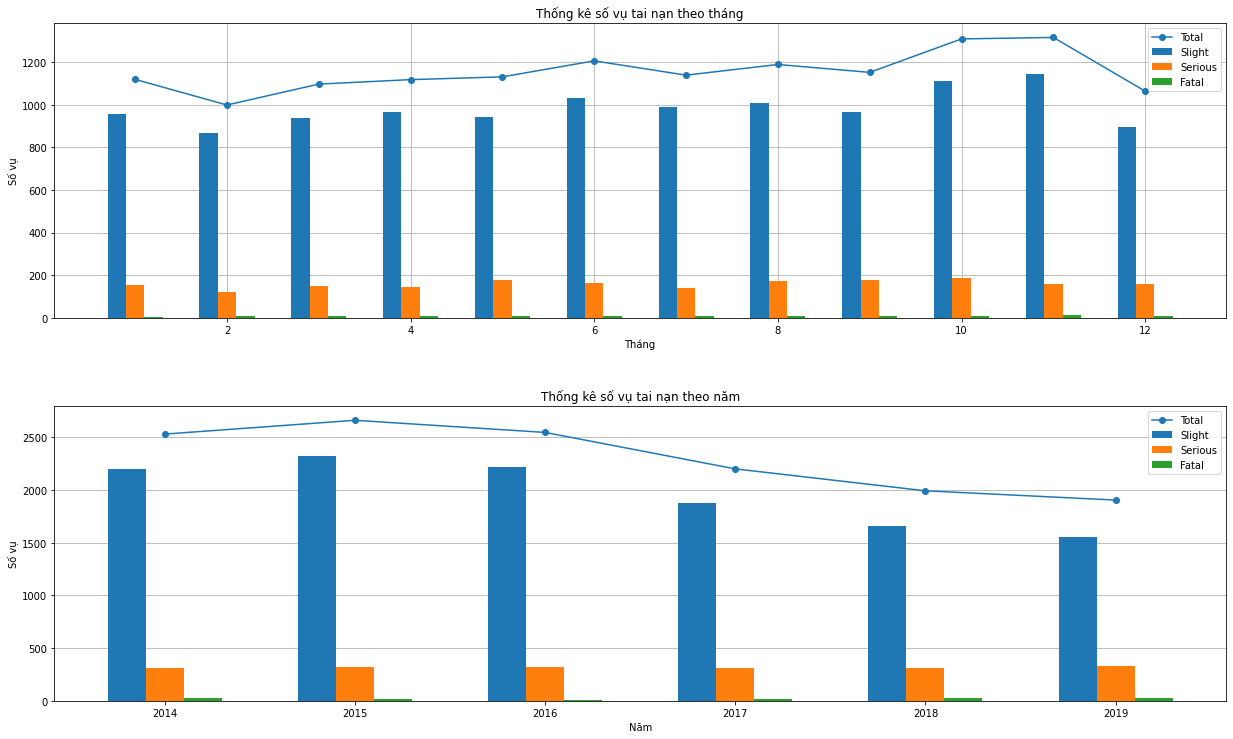

In [10]:
# tổng hợp số vụ theo tháng và vẽ bằng line chart rồi nhận xét
fig, axs = plt.subplots(2,1, figsize=(17,10))
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)

month = df['Accident Date'].str[5:7].astype(int)
monthCount = month.value_counts().sort_index()
fatal = dict(df[df['Casualty Severity']=='Fatal']['Casualty Severity'].groupby([month]).count())
serious = dict(df[df['Casualty Severity']=='Serious']['Casualty Severity'].groupby([month]).count())
slight = dict(df[df['Casualty Severity']=='Slight']['Casualty Severity'].groupby([month]).count())
axs[0].plot(monthCount.index, monthCount.values, '-o', label='Total')
# axs[0].plot(list(slight.keys()), list(slight.values()), label='Slight')
# axs[0].plot(list(serious.keys()), list(serious.values()), label='Serious')
# axs[0].plot(list(fatal.keys()), list(fatal.values()), label='Fatal')
xx = np.arange(1,13)
width = 0.2
axs[0].bar(xx-width, slight.values(), width, label='Slight', zorder=3)
axs[0].bar(xx, serious.values(), width, label='Serious', zorder=3)
axs[0].bar(xx+width, fatal.values(), width, label='Fatal', zorder=3)

axs[0].grid(b=True)
axs[0].legend()
axs[0].set_title('Thống kê số vụ tai nạn theo tháng')
axs[0].set_xlabel('Tháng')
axs[0].set_ylabel('Số vụ')

year = df['Accident Date'].apply(lambda x: x[:4])
yearCount = year.value_counts().sort_index()
fatal1 = dict(df[df['Casualty Severity']=='Fatal']['Casualty Severity'].groupby([year]).count())
serious1 = dict(df[df['Casualty Severity']=='Serious']['Casualty Severity'].groupby([year]).count())
slight1 = dict(df[df['Casualty Severity']=='Slight']['Casualty Severity'].groupby([year]).count())
# width = 0.1
x = np.arange(len(year.value_counts()))
axs[1].bar(x-width, slight1.values(), width, label='Slight', zorder=3)
axs[1].bar(x, serious1.values(), width, label='Serious', zorder=3)
axs[1].bar(x+width, fatal1.values(), width, label='Fatal', zorder=3)
axs[1].set_xticklabels(yearCount.index, rotation=0)
axs[1].legend()
axs[1].grid(b=True, axis='y', zorder=0)
axs[1].plot(yearCount.index, yearCount.values, '-o', label='Total')
axs[1].legend()
axs[1].set_title('Thống kê số vụ tai nạn theo năm')
axs[1].set_xlabel('Năm')
axs[1].set_ylabel('Số vụ')

- Từ năm 2014 đến năm 2019, số lượng tai nạn giảm dần. Chứng tỏ sự phát triển ngày càng tiến bộ trong lĩnh vực quản lý giao thông. Tuy nhiên, số tai nạn nghiêm trọng và số ca tử vong gần như giữ nguyên theo từng năm.
- Trong thống kê dưới đây, có một vài khoảng thời gian trong năm, số lượng vụ tai nạn biến động một cách bất thường so với các khoảng thời gian còn lại:
    - Đầu tháng 12 đến đầu tháng 1: Đây thời gian diễn ra Giáng Sinh và tết Dương lịch, đây là khoảng thời gian nghỉ lễ của gia đình sau một năm làm việc. Do đó, Tai nạn thường giảm vào khoảng thời gian này.
    - Tháng 2 là khoảng thời gian xảy ra ít tai nạn nhất trong 12 tháng
    - Đầu tháng 5 đến đầu tháng 9, số lượng vụ tai nạn giao thông biến động thất thường.
    - Tháng 10, 11: Đây là nơi diễn ra 2 ngày lễ lớn của UK là Quốc Khánh và Lễ Tạ ơn, người ta có xu hướng sẽ đi du lịch hoặc trở về từ thành phố cùng gia đình. Do đó số lượng tai nạn tăng lên. Theo thống kê trên, đây là khoảng thời gian xảy ra tai nạn nhiều nhất trong 6 năm
- Các khoảng thời gian còn lại, số lượng tai nạn biến động nhẹ.

### **Vị trí các vụ tai nạn**

In [11]:
%%HTML
<div class='tableauPlaceholder' id='viz1622210582634' style='position: relative'><noscript><a href='#'><img alt=' ' src='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;J3&#47;J34DXXGX6&#47;1_rss.png' style='border: none' /></a></noscript><object class='tableauViz'  style='display:none;'><param name='host_url' value='https%3A%2F%2Fpublic.tableau.com%2F' /> <param name='embed_code_version' value='3' /> <param name='path' value='shared&#47;J34DXXGX6' /> <param name='toolbar' value='yes' /><param name='static_image' value='https:&#47;&#47;public.tableau.com&#47;static&#47;images&#47;J3&#47;J34DXXGX6&#47;1.png' /> <param name='animate_transition' value='yes' /><param name='display_static_image' value='yes' /><param name='display_spinner' value='yes' /><param name='display_overlay' value='yes' /><param name='display_count' value='yes' /><param name='language' value='en-US' /></object></div>                <script type='text/javascript'>                    var divElement = document.getElementById('viz1622210582634');                    var vizElement = divElement.getElementsByTagName('object')[0];                    vizElement.style.width='100%';vizElement.style.height=(divElement.offsetWidth*0.75)+'px';                    var scriptElement = document.createElement('script');                    scriptElement.src = 'https://public.tableau.com/javascripts/api/viz_v1.js';                    vizElement.parentNode.insertBefore(scriptElement, vizElement);                </script>

- Quan sát dữ liệu, ta thấy dữ liệu có tính tập trung và mật độ tập trung là rất cao. Do đó, khi sử dụng các thuật toán gom nhóm dựa trên mật độ, có thể cho kết quả là 1 cụm duy nhất
- Sử dụng thuật toán K-Means để tìm các khu vực thường xuyên gây tai nạn
    - Thử nghiệm phân cụm với số phân cụm từ 2 đến 20 và sử dụng độ đo `Silhouette` và `Davies-Bouldin` để đánh giá kết quả phân cụm. Việc sử dụng nhiều hơn 1 độ đo tạo cơ sở để đối chiếu kết quả, từ đó có thể chọn ra số phân cụm hợp lý nhất. Trong đó:
    - Với độ đo `Silhouette`: giá trị trong đoạn $[-1, 1]$. Kết quả càng cao thì mô hình định nghĩa các cụm tốt hơn.
    - Với độ đo `Davies-Bouldin`: giá trị trong đoạn $[0, \infty)$. Mô hình gom nhóm có kết quả càng gần 0 thì càng phân cụm tốt.

$*$ Tham khảo: https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation



Best n_clusters (highest Silhouette Coefficient): 15
	Silhouette Coefficient = 0.39589042321923307

Best n_clusters (lowest Davies-Bouldin Index): 9
	Davies-Bouldin Index = 0.7538851912793627


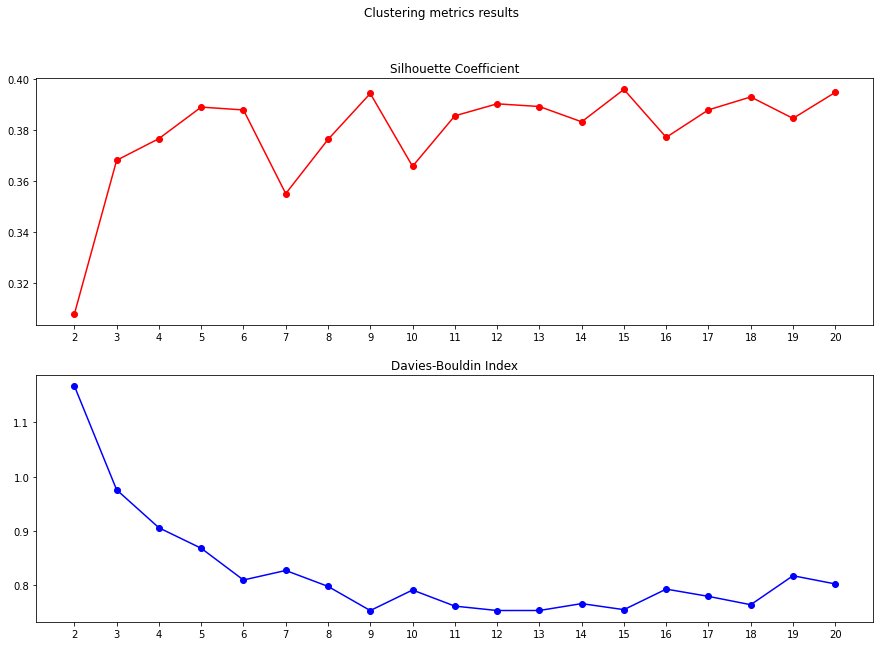

In [16]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

traffic_coords = pd.read_csv('../Data/afterPreprocess.csv', usecols=['Grid Ref: Easting', 'Grid Ref: Northing'])
# traffic_coords.value_counts()

cluster_model = KMeans(max_iter=1000, random_state=0)

# thử với nhiều cụm (2-20)
n_clusters = list(range(2, 21))
labels = []
for k in n_clusters:
    cluster_model.set_params(n_clusters=k)
    labels.append(cluster_model.fit_predict(traffic_coords))

# tính điểm của các phân cụm theo 2 độ đo
silhouette_scores = [silhouette_score(traffic_coords, l, random_state=42) for l in labels]
davies_bouldin_scores = [davies_bouldin_score(traffic_coords, l) for l in labels]

# biểu diễn điểm phân cụm
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
fig.suptitle('Clustering metrics results')
plt.sca(ax[0])
plt.plot(n_clusters, silhouette_scores, 'o-r')
plt.xticks(n_clusters)
plt.title('Silhouette Coefficient')
plt.sca(ax[1])
plt.plot(n_clusters, davies_bouldin_scores, 'o-b')
plt.xticks(n_clusters)
plt.title('Davies-Bouldin Index')

print(f'Best n_clusters (highest Silhouette Coefficient): {n_clusters[silhouette_scores.index(max(silhouette_scores))]}')
print(f'\tSilhouette Coefficient = {max(silhouette_scores)}')
print()
print(f'Best n_clusters (lowest Davies-Bouldin Index): {n_clusters[davies_bouldin_scores.index(min(davies_bouldin_scores))]}')
print(f'\tDavies-Bouldin Index = {min(davies_bouldin_scores)}')

- 2 độ đo trên cho kết quả khác nhau (9 và 15). Cần kiểm tra xem giữa k=9 và k=15, cái nào tốt hơn

In [17]:
n_15_idx = n_clusters.index(15)
n_9_idx = n_clusters.index(9)

print('Difference between scores of 9 & 15 clusters:')
print('Silhouette Coefficient: ', end='')
print(abs(silhouette_scores[n_15_idx] - silhouette_scores[n_9_idx]))

print('Davies-Bouldin Index: ', end='')
print(abs(davies_bouldin_scores[n_15_idx] - davies_bouldin_scores[n_9_idx]))

Difference between scores of 9 & 15 clusters:
Silhouette Coefficient: 0.0015875010414521107
Davies-Bouldin Index: 0.001664842081454454


- Sự chênh lệch giữa 2 lựa chọn là không nhiều. Do đó, chọn k=9 để việc phân tích được đơn giản hơn
- Sau khi chạy thuật toán với k=9, in ra các tâm cụm và trực quan các tâm cụm này trên bản đồ
- Quan sát các khu vực này và ghi nhận lại địa chỉ

In [18]:
cluster_model.set_params(n_clusters=9)
traffic_coords['Labels'] = cluster_model.fit_predict(traffic_coords)
(cluster_model.cluster_centers_).round(0)

# kết quả trực quan: https://gridreferencefinder.com?gr=SE2950033274|429500_s__c__s_433274|1,SE3336735557|433367_s__c__s_435557|1,SE2072542697|420725_s__c__s_442697|1,SE3315327609|433153_s__c__s_427609|1,SE4123633044|441236_s__c__s_433044|1,SE2697327964|426973_s__c__s_427964|1,SE2891338595|428913_s__c__s_438595|1,SE2393835047|423938_s__c__s_435047|1,SE4051545030|440515_s__c__s_445030|1&v=r&labels=1

array([[429500., 433274.],
       [433367., 435557.],
       [420725., 442697.],
       [440515., 445030.],
       [433153., 427609.],
       [441236., 433044.],
       [426973., 427964.],
       [428913., 438595.],
       [423938., 435047.]])

In [19]:
import re

address_df = pd.read_csv('../Data/address.csv', usecols=['Address (near)'])
address_df['Counts'] = (traffic_coords.groupby('Labels').size())

pd.options.display.max_colwidth = None
address_df.sort_values('Counts', ascending=False, inplace=True)

address_df['Address (near)'] = address_df['Address (near)'].apply(lambda x: x[:re.search('Leeds', x).start() - 2])
address_df.index.set_names('Labels', inplace=True)
address_df

Address (near)  \
Labels                                                                                   
0                                           Whitehall Riverside, Holbeck Urban Village   
1                                                            Amberton Approach, Gipton   
8                                                             Compton Lane, Collingham   
6                                                    Ring Road Meanwood, Moor Allerton   
7       Bramley Service Reservoir, Fairfield Square, Fairfield Estate, Bramley, Pudsey   
4                                                           Cricketers Close, Garforth   
5                                          Miners Fisheries, 2a, Clough Street, Morley   
2                                                        West Carlton, Carlton, Yeadon   
3               Leadwell Lane Northfield Avenue, Leadwell Lane, Howlett Cross, Carlton   

        Counts  
Labels          
0         4183  
1         2414  
8         1629  
6         1315  
7         1264  
4         1225  
5          725  
2          711  
3          373

<AxesSubplot:xlabel='Grid Ref: Easting', ylabel='Grid Ref: Northing'>

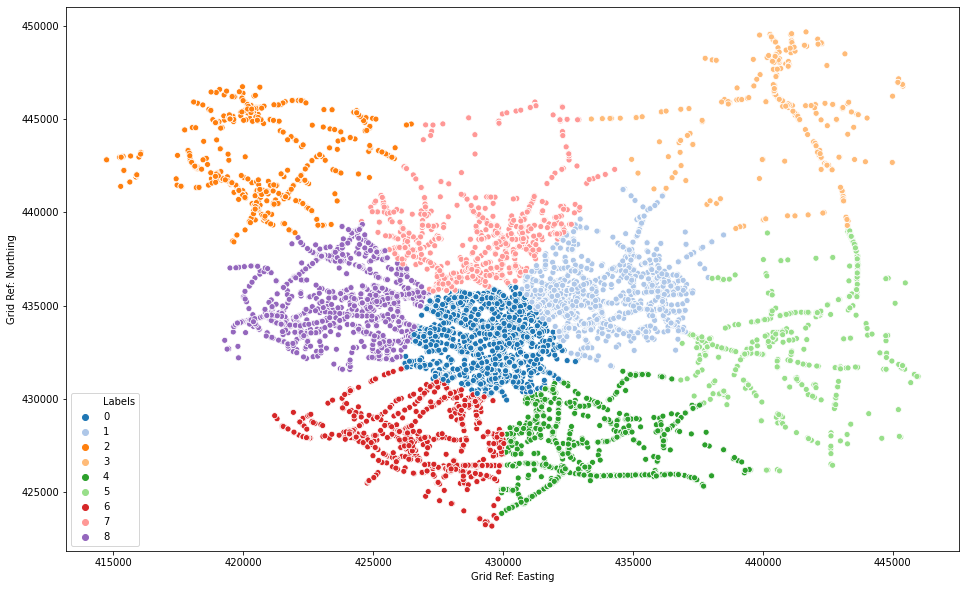

In [20]:
# kết quả phân lớp
fig, ax = plt.subplots(figsize=(16, 10))
sns.scatterplot(data=traffic_coords, x='Grid Ref: Easting', y='Grid Ref: Northing', hue='Labels', palette='tab20', ax=ax)

## Tìm hiểu mối tương quan giữa các thuộc tính và mức độ nghiêm trọng của tai nạn

- Xác định hệ số tương quan và mức ý nghĩa đối với thống kê mà giữa các thuộc tính với thuộc tính mức độ nghiêm trọng của vụ tai nạn
- Từ đó biểu diễn các thuộc tính có hệ số tương quan và mức ý nghĩa cao để nhìn nhận vấn đề sâu sắc hơn

### Đối với các thuộc tính định danh

- Sử dụng Chi-Square test để kiểm định mức ý nghĩa giữa các thuộc tính này với thuộc tính 'Casualty Severity'. Nói cách khác, đây là kiểm định nhằm kiểm tra mối quan hệ giữa 'Casualty Severity' và các thuộc tính định danh khác
- Tham khảo [Chi-Square](https://www.analyticsvidhya.com/blog/2019/11/what-is-chi-square-test-how-it-works/)

In [21]:
categoryAttributes = ['Number of Vehicles', '1st Road Class', 'Road Surface','Lighting Conditions',
                      'Weather Conditions', 'Type of Vehicle','Casualty Class', 'Sex of Casualty']

class ChiQuare:
    def __init__(self, df):
        self.df = df
        self.pValue = None
        self.observedValue = None 

    def chiSquareTest(self, colX, colY='Casualty Severity', alpha=0.01):
        self.observedValue = pd.crosstab(self.df[colX], self.df[colY])
        _, self.pValue, _, _ = chi2_contingency(self.observedValue)
        self._printResult(colX, alpha)

    def _printResult(self, colX, alpha):
        if self.pValue < alpha:
            print(f'{colX} có ý nghĩa về mặt thống kê (p-value = {self.pValue})')

chi_sq = ChiQuare(df)
for category in categoryAttributes:
    chi_sq.chiSquareTest(category)

Number of Vehicles có ý nghĩa về mặt thống kê (p-value = 2.8486717697240694e-66)
1st Road Class có ý nghĩa về mặt thống kê (p-value = 5.12000972161323e-10)
Road Surface có ý nghĩa về mặt thống kê (p-value = 0.0032592803025384173)
Lighting Conditions có ý nghĩa về mặt thống kê (p-value = 1.0097104578862578e-09)
Weather Conditions có ý nghĩa về mặt thống kê (p-value = 0.00016530571198789491)
Type of Vehicle có ý nghĩa về mặt thống kê (p-value = 2.3556874142608483e-142)
Casualty Class có ý nghĩa về mặt thống kê (p-value = 7.652670909724906e-84)
Sex of Casualty có ý nghĩa về mặt thống kê (p-value = 2.0864773191641376e-35)


- Từ các khảo sát trên, ta thấy cả 8 thuộc tính định danh đều có ý nghĩa về mặt thống kê (p-value rất nhỏ)
- Thực hiện phân tích tương quan của 4 thuộc tính có p-value nhỏ nhất: `Type of Vehicle`, `Casualty Class`, `Number of Vehicle`, `Sex of Casualty`
- 2 thuộc tính `Casualty Class` và `Sex of Casualty` sẽ được trình bày chung trong phần "Thuộc tính liên tục"

#### **`Number of Vehicle` vs. `Casualty Severity`**

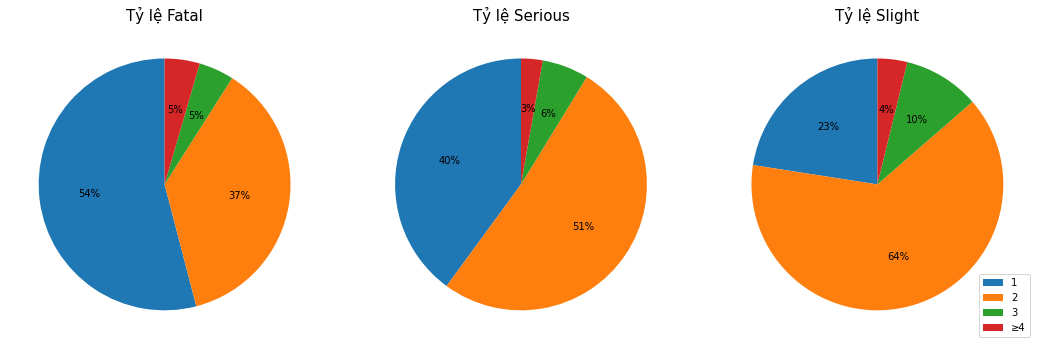

In [22]:
def attributeVsCasualtySeverity(colName, df):
    fatal = dict(df[df['Casualty Severity']=='Fatal']['Casualty Severity'].groupby(df[colName]).count())
    serious = dict(df[df['Casualty Severity']=='Serious']['Casualty Severity'].groupby(df[colName]).count())
    slight = dict(df[df['Casualty Severity']=='Slight']['Casualty Severity'].groupby(df[colName]).count())
    tmpDf = pd.DataFrame(data=[fatal, serious, slight], index=['fatal', 'serious', 'slight']).T
    sumFatal = np.sum(tmpDf['fatal'])
    sumSerious = np.sum(tmpDf['serious'])
    sumSlight = np.sum(tmpDf['slight'])
    tmpDf['fatal'] = tmpDf['fatal']/sumFatal * 100
    tmpDf['serious'] = tmpDf['serious']/sumSerious * 100
    tmpDf['slight'] = tmpDf['slight']/sumSlight * 100

    labels = list(tmpDf.index)
    fig, axs = plt.subplots(1, 3, figsize=(15,5))
    fig.tight_layout()
    _,texts,_ = axs[0].pie(tmpDf['fatal'], autopct='%1.f%%', startangle=90)
    axs[0].set_title('Tỷ lệ Fatal', fontsize=15)
    _,texts,_ = axs[1].pie(tmpDf['serious'], autopct='%1.f%%', startangle=90)
    axs[1].set_title('Tỷ lệ Serious', fontsize=15)
    _,texts,_ = axs[2].pie(tmpDf['slight'], autopct='%1.f%%', startangle=90)
    axs[2].set_title('Tỷ lệ Slight', fontsize=15)
    plt.legend(labels, loc='lower right')

attributeVsCasualtySeverity('Number of Vehicles', df)

- Nhận xét
    - Với số lượng xe = 1, khả năng tự gây tai nạn nghiêm trọng rất cao (54% trong số các ca tử vong và 40% trong số các ca nghiêm trọng)
    - Với số lượng xe = 2, mức độ tai nạn giảm xuống (số ca tử vong giảm), tuy nhiên tần xuất xảy ra tai nạn lại tăng lên (51% trong số các ca nghiêm trọng và 64% trong số các ca tai nạn nhẹ)
    - Tỷ lệ xuất hiện của các vụ tai nạn từ 3 xe trở lên khá thấp. Mức độ nghiêm trọng phân khá đều cho số vụ tai nạn

#### **`Type of Vehicle` vs `Casualty Severity`**

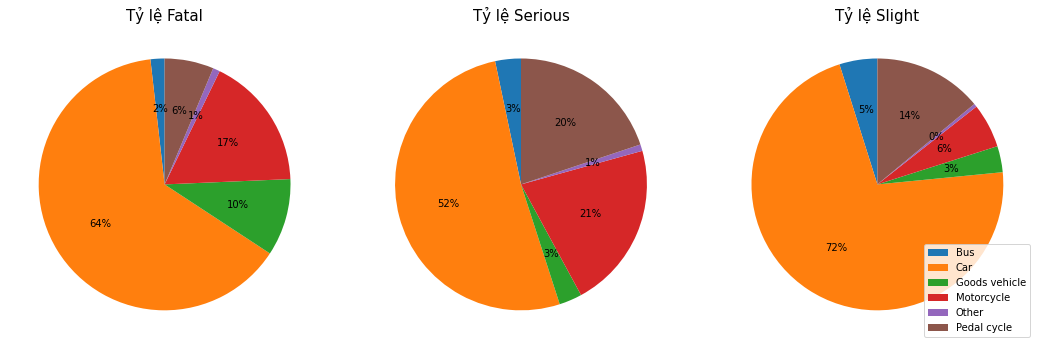

In [23]:
attributeVsCasualtySeverity('Type of Vehicle', df)

- Nhận xét
    - Xe máy là loại phương tiện dễ gây tử vong hoặc tai nạn nghiêm trọng nhất (17% trong số các ca tử vong và 21% trong số các ca nghiêm trọng)
    - Khi đi xe hơi rất dễ xảy ra tai nạn với các mức tai nạn nhẹ có tần suất cao nhất (72%), sau đó là tử vong (64%) và nghiêm trọng (52%)
    - Xe đạp là loại phương tiện dễ gây tai nạn nghiêm trọng (20%, chỉ xếp sau xe máy 1%) và tai nạn nhẹ (14%)

### Đối với thuộc tính liên tục

- Có 2 thuộc tính liên tục chưa khảo sát: "Time (24hr)" và "Age of Casualty"
- Khảo sát cả 2 thuộc tính này

#### **Thống kê khung thời gian xảy ra tai nạn trong ngày**


Text(0.5, 1.0, 'So sánh số lượng tai nạn trong các khoảng giờ cao điểm')

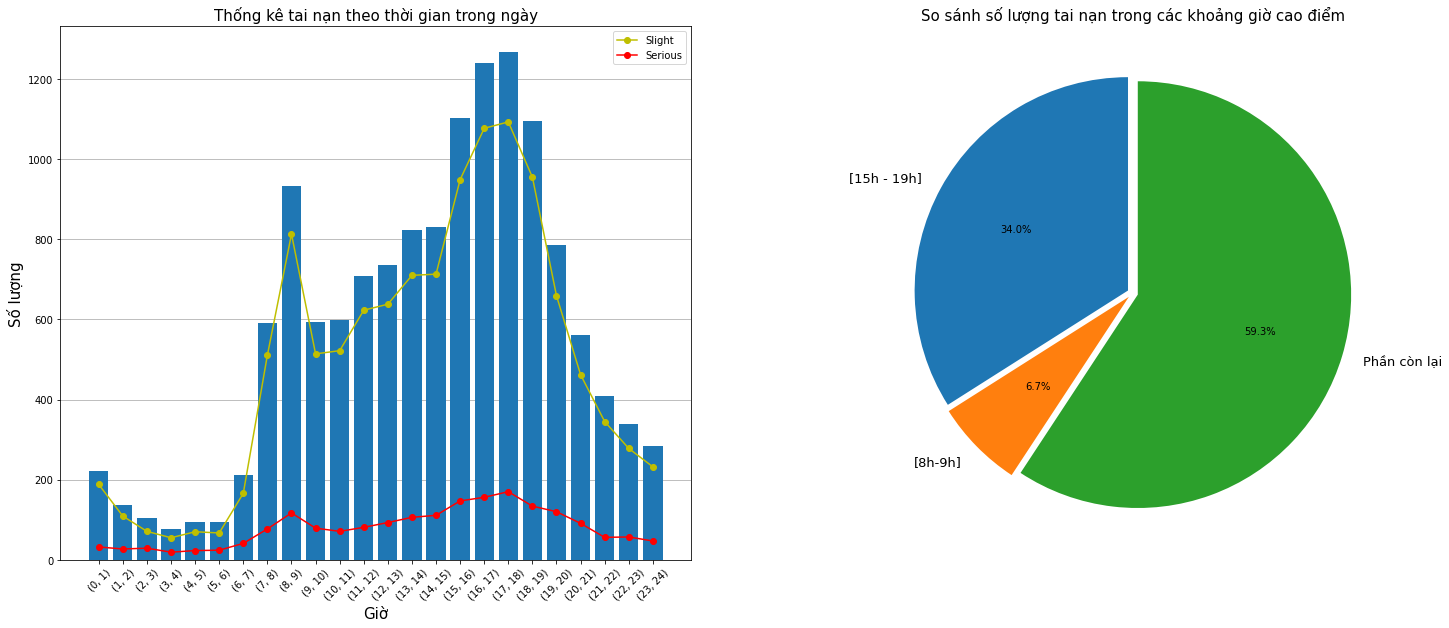

In [24]:
x_axis = makeXAxis(0,1,24)
y_axis = makeYAxis(df['Time (24hr)'].apply(lambda x: int(x[:2]) + int(x[3:5])/60), x_axis)

count1519 = np.sum(y_axis[-9:-5])/np.sum(y_axis)*100
count8 = np.sum(y_axis[8])/np.sum(y_axis)*100
sizePie = [count1519, count8, 100-count1519-count8]
labels = ['[15h - 19h]', '[8h-9h]', 'Phần còn lại']

fig, axs = plt.subplots(1,2, figsize=(20,8))
fig.tight_layout()
fig.subplots_adjust(wspace=0.2)

hour = df['Time (24hr)'].apply(lambda x: int(x[0:2]))
serious = dict(df[df['Casualty Severity']=='Serious']['Casualty Severity'].groupby([hour]).count())
fatal = dict(df[df['Casualty Severity']=='Fatal']['Casualty Severity'].groupby([hour]).count())
slight = dict(df[df['Casualty Severity']=='Slight']['Casualty Severity'].groupby([hour]).count())
axs[0].plot(list(slight.keys()), list(slight.values()), '-yo', label='Slight', zorder=10)
axs[0].plot(list(serious.keys()), list(serious.values()), '-ro', label='Serious', zorder=10)
# axs[0].plot(list(fatal.keys()), list(fatal.values()), '-k', label='Fatal', zorder=10)
axs[0].bar([str(i) for i in x_axis], y_axis, zorder=3)
axs[0].set_xticklabels([str(i) for i in x_axis], rotation=45)
axs[0].grid(b=True, zorder=0, axis='y')
axs[0].set_xlabel('Giờ', fontsize=15)
axs[0].set_ylabel('Số lượng', fontsize=15)
axs[0].set_title('Thống kê tai nạn theo thời gian trong ngày', fontsize=15)
axs[0].legend()

explode = (0.025, 0.025, 0.025)
_,texts,_ = axs[1].pie(sizePie, explode=explode, labels=labels, autopct='%1.1f%%', startangle=90)
texts[0].set_fontsize(13)
texts[1].set_fontsize(13)
texts[2].set_fontsize(13)
axs[1].set_title('So sánh số lượng tai nạn trong các khoảng giờ cao điểm', fontsize=15)

- Khoảng thời gian cao điểm của tai nạn giao thông trong ngày rơi vào từ 7 giờ đến 20 giờ. Có thể chia ra làm 2 khoảng cao điểm chính:
	- Từ 8h đến 9h: Khoảng thời gian bắt đầu đi làm. Số vụ tai nạn xảy ra trong khoảng thời gian này chiếm 6.7% (~927 vụ) tổng số vụ xảy ra trong 6 năm
	- Từ 15h đến 19h: Khoảng thời gian tan làm, đỉnh điểm rơi vào 1 tiếng đồng hồ từ 16h đến 17h. Trong khoảng thời gian này, số vụ tai nạn chiếm 34% (~4.700 vụ) tổng số vụ tai nạn xảy ra trong 6 năm.
- Mức độ của các vụ tai nạn theo 2 khung giờ này cũng tăng lên
    - Mức độ nhẹ của các vụ tai nạn từ (6h đến 9h) và từ (14h đến 18h) tăng một cách đột biến
    - Mức độ nghiêm trọng trong 2 khoảng thời gian này cũng tăng lên đột ngột
- Do đó, cần chú ý khi tham gia giao thông vào giờ cao điểm.

#### **Thống kê tai nạn tại các khung giờ của các ngày trong tuần**

Text(0.5, 1.0, 'Thống kê tai nạn tại các khung giờ của các ngày trong tuần')

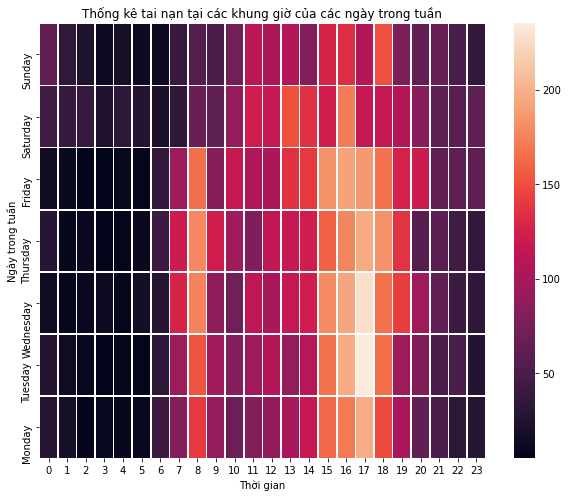

In [26]:
dayOfWeek = pd.to_datetime(df['Accident Date']).dt.dayofweek
map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
dayOfWeek = dayOfWeek.map(map)
hour = df['Time (24hr)'].apply(lambda x: int(x[0:2]))

l_dow = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
l_dow.reverse()
l_hour = list(range(24))

matrix = np.zeros((len(l_dow), len(l_hour)))

for i in range(len(df)):
    x = l_dow.index(dayOfWeek[i])
    y = l_hour.index(hour[i])
    matrix[x][y] = matrix[x][y] + 1
matrix = matrix.astype('int')
matrix_df = pd.DataFrame(matrix, index = l_dow, columns = l_hour)
# sns.set_theme()
plt.figure(figsize=(10,8))
ax = sns.heatmap(matrix_df, linewidths=.5)
ax.set_xlabel('Thời gian')
ax.set_ylabel('Ngày trong tuần')
ax.set_title('Thống kê tai nạn tại các khung giờ của các ngày trong tuần')

- Nhìn vào biểu đồ trên, ta thấy 2 khoảng giờ cao điểm nêu trên từ thứ 2 đến thứ 6
- Các ngày nghỉ (T7, CN): khoảng cao điểm này không còn rõ nét nữa do số lượng người đi làm vào 2 ngày này giảm đáng kể.

####**Liên hệ giữa độ tuổi, giới tính, đối tượng tai nạn và mức độ nghiêm trọng của tai nạn**
- Visualize thống kê theo độ tuổi, giới tính và thống kê theo đối tượng bị tai nạn
- Tìm hiểu mối quan hệ giữa 2 thống kê này

Text(0, 0.5, 'Số vụ')

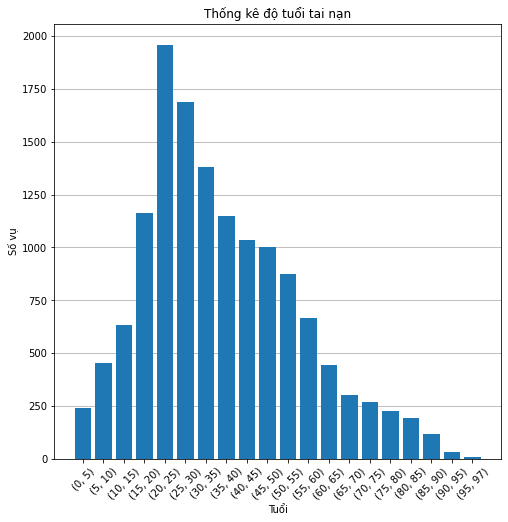

In [27]:
x_axis = makeXAxis(start=0, step=5, end=np.max(df['Age of Casualty']))
y_axis = makeYAxis(df['Age of Casualty'],x_axis)
plt.figure(figsize=(8,8))
plt.xticks(rotation = 45)
plt.bar([str(i) for i in x_axis], y_axis, zorder=3)
plt.grid(b=True, axis='y', zorder=0)
plt.title('Thống kê độ tuổi tai nạn')
plt.xlabel('Tuổi')
plt.ylabel('Số vụ')

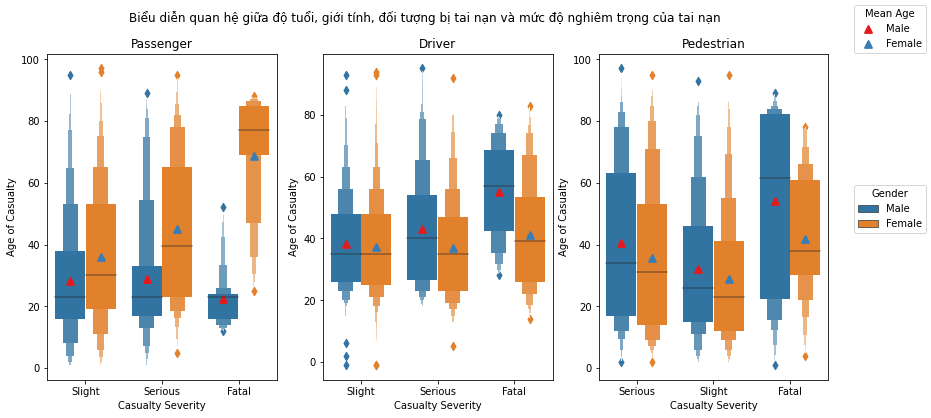

In [28]:
casualty_class = df['Casualty Class'].unique()

fig, axes = plt.subplots(1, 3, figsize=(14, 6))
fig.suptitle('Biểu diễn quan hệ giữa độ tuổi, giới tính, đối tượng bị tai nạn và mức độ nghiêm trọng của tai nạn')
for i in range(len(casualty_class)):
    data_df = df[df['Casualty Class'] == casualty_class[i]]
    sns.boxenplot(data=data_df, x='Casualty Severity', y='Age of Casualty', hue='Sex of Casualty', ax=axes[i])
    sns.pointplot(data=data_df, x='Casualty Severity', y='Age of Casualty', hue='Sex of Casualty',
                  linestyles='None', errwidth=0, dodge=0.4, markers=['^', '^'], palette='Set1', ax=axes[i])
    
    axes[i].get_legend().remove()
    axes[i].set_title(casualty_class[i])
    axes[i].grid(False)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles[:2], labels[:2], title='Gender', loc='center right')
fig.legend(handles[2:], labels[2:], title='Mean Age', loc='upper right')

- Quan sát cả 2 biểu đồ trên, có thể kết luận rằng
    - Độ tuổi dễ gây tai nạn giao động từ 15 đến 50.
    - Độ tuổi bị tai nạn trung bình của nữ thấp hơn nam đối với đối tượng bị tai nạn là người điều khiển phương tiện và người đi bộ. Đối với đối tượng là hành khách đi cùng, độ tuổi trung bình của nữ cao hơn nam.
    - Trong đó
        - Đối với đối tượng tai nạn là hành khách đi cùng, nữ chiếm đa số. Do điều kiện sức khoẻ cũng như khả năng phản ứng của nữ thường thấp hơn nam nên số ca nữ thường nhiều hơn và bị thương nặng hơn.
        - Đối với đối tượng tai nạn là người điều khiển phương tiện, tỷ lệ gây tai nạn là như nhau; số ca tử vong của nữ nhiều hơn nam và phân bố từ khoảng 16 đến trên 80 tuổi; độ tuổi từ khoảng 22-58 đối với nữ, 40-68 đối với nam có tỷ lệ tử vong do điều khiển phương tiện cao nhất. Dễ thấy, các đối tượng gây/bị tai nạn đang trong độ tuổi của sự nghiệp. Việc vội vàng trong công việc ở một đất nước như UK là hoàn toàn có thể hiểu được.
        - Đối với người đi bộ, nam giới gây/bị tai nạn nhiều hơn nữ giới. Quan sát đường trung vị ở nam giới tử vong, ta thấy hơn 50% các trường hợp này có độ tuổi trên 60. Do đó, đối tượng nam là người già cần phải chú ý khi tham gia giao thông hoặc khi ra đường, cần có người bảo hộ đi cùng.
    - Đặc biệt, đối với đối tượng tai nạn là người điều khiển phương tiện, xuất hiện các vụ tai nạn với độ tuổi kéo dài từ 0-20 tuổi và mức độ từ nhẹ đến nghiêm trọng. Trong khi độ tuổi được phép lái xe là từ 16 tuổi. Do đó, phụ huynh cần chú ý đến hành vi của trẻ trong độ tuổi này để tránh tai nạn đáng tiếc.

## Rút trích luật từ cây quyết định

- Sử dụng cây quyết định để tìm các luật về mức độ nghiêm trọng khi xảy ra tai nạn. Thuộc tính lớp: `Casualty Severity`. Từ đó xác định được các thuộc tính quan trọng ảnh hưởng đến phân lớp.
- Cây quyết định được setup với chiều cao tối đa là 5, sử dụng độ đo `gini` để phân hoạch.

In [29]:
# encode dữ liệu để đưa vào model
feature_cols = ['Time (24hr)', 'Number of Vehicles', '1st Road Class', 'Road Surface','Lighting Conditions', 'Weather Conditions','Type of Vehicle', 'Casualty Class', 'Sex of Casualty','Age of Casualty']
X = df[feature_cols]        # attributes
X['Time (24hr)'] = X['Time (24hr)'].apply(lambda x: int(x[:2]) + int(x[3:5])/60)
y = df['Casualty Severity'] # class

realValues = {} # lưu lại giá trị thực sau khi encode
numberEncoder = preprocessing.LabelEncoder()
for col in feature_cols[1:9]:
    X[col] = numberEncoder.fit_transform(X[col])
    realValues[col] = numberEncoder.classes_

def evaluate(model, features_testset, targets_testset, label):
    targets_pred = model.predict(features_testset)
    print(classification_report(targets_testset, targets_pred))
    plot_confusion_matrix(model, features_testset, targets_testset,
                                 display_labels=label.sort(),
                                 cmap=plt.cm.Blues,
                                 normalize='true')
    plt.show()

In [32]:
# visualize decision tree
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
# from six import StringIO
from IPython.display import Image  
import pydotplus

dt = DecisionTreeClassifier(criterion="gini", max_depth=5)
dt.fit(X, y)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=feature_cols, class_names=dt.classes_)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('rules.png')

Image(graph.create_png())
evaluate(dt, X, y, list(y.value_counts().index))

InvocationException: GraphViz's executables not found

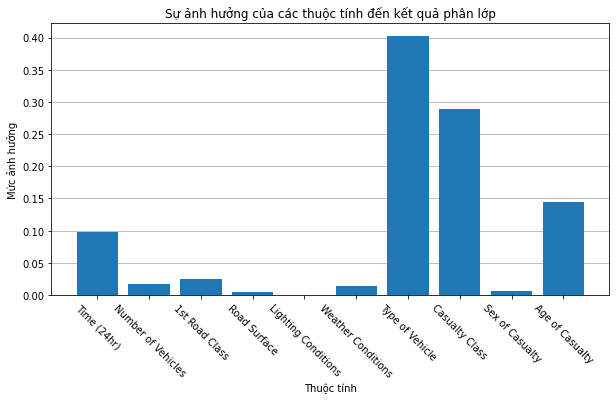

In [33]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(X.columns, dt.feature_importances_):
    feats[feature] = importance # add the name/value pair 

draw(feats.keys(), feats.values(), title='Sự ảnh hưởng của các thuộc tính đến kết quả phân lớp', x_label='Thuộc tính', y_label='Mức ảnh hưởng',size=(10,5), rotation=-45)

- Từ biểu đồ trên, **các thuộc tính có ảnh hưởng lớn đến mức độ nghiêm trọng của một vụ tai nạn** bao gồm
    - Thời gian tham gia giao thông trong ngày
    - Loại phương tiện sử dụng (giống với kết quả kiểm định)
    - Đối tượng bị tai nạn (giống với kết quả kiểm định)
    - Độ tuổi bị tai nạn

## Dự đoán mức độ nghiêm trọng của tai nạn

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=69)

**Phân bố của phân lớp**

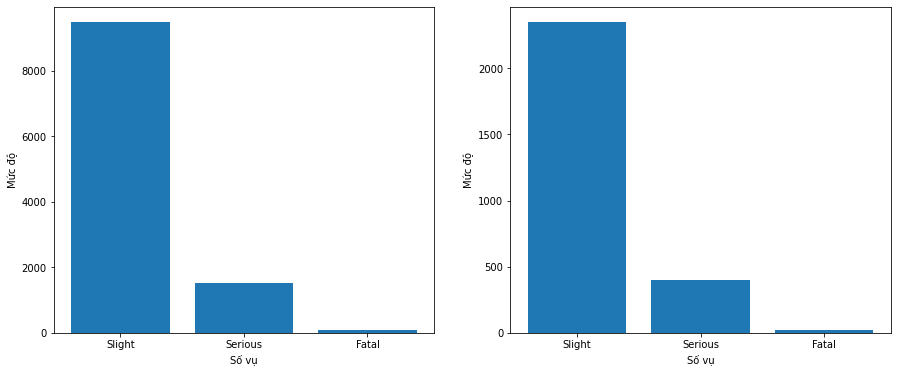

In [35]:
def distributionOfData(y_train, y_test):
    severity_train = y_train.value_counts()
    severity_test = y_test.value_counts()
    fig, axs = plt.subplots(1,2,figsize=(15,6))

    axs[0].bar(severity_train.index, severity_train.values)
    axs[0].set_xlabel('Số vụ')
    axs[0].set_ylabel('Mức độ')

    axs[1].bar(severity_test.index, severity_test.values)
    axs[1].set_xlabel('Số vụ')
    axs[1].set_ylabel('Mức độ')

distributionOfData(y_train, y_test)

- Rõ ràng, phân bố lớp như trên bị mất cân bằng nghiêm trọng. Giả sử áp dụng kỹ thuật tái lấy mẫu cân bằng (`BalancedBagging`) thì cũng rất có khả năng xảy ra hiện tượng overfitting vì số lượng `Fatal` là rất nhỏ. Do đó, ta gộp `Fatal` và `Serious` lại thành `Serious`
- Ngoài ta, phân bố của tập train và tập test là đều nhau

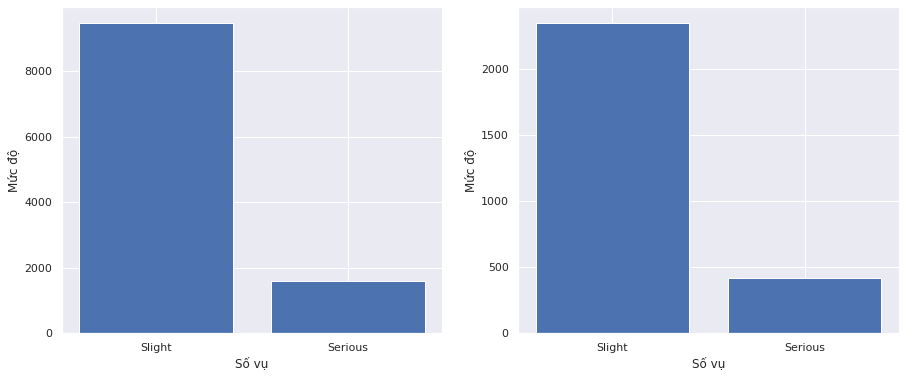

In [29]:
y_train[y_train=='Fatal'] = 'Serious'
y_test[y_test=='Fatal'] = 'Serious'
distributionOfData(y_train, y_test)

- **Các phương pháp được áp dụng**
    - Balanced Bagging Classifier
    - Random Forest with class weighting (`class_weight='balanced'`)
    - Random Forest with bootstrap class weighting (`class_weight='balanced_subsample'`)
    - Random Forest with Random Undersampling (`BalancedRandomForestClassifier`)

- Tham khảo cách chọn siêu tham số
    - https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/
    - https://engineering.linecorp.com/en/blog/abuser-detection-random-forest-model-and-hyperparameter-tuning/

### Balanced Bagging Classifier

In [30]:
%%time
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 250, num = 3)]
# Number of features to consider at every split
max_features = list(range(1, int(len(X_train.columns)/2)))
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Bootstrap feature
bootstrap_features = [True, False]

# Create the random grid
params = {'n_estimators': n_estimators,
          'max_features': max_features,
          'bootstrap': bootstrap,
          'bootstrap_features': bootstrap_features}


baggingClassifier = BalancedBaggingClassifier()
# Grid search of parameters, using 3 fold cross validation
# search across 100 different combinations, and use all available cores
bagging_grid_search = GridSearchCV(estimator=baggingClassifier, param_grid=params, cv=3, verbose=2, n_jobs=-1)
# Fit the random search model
bagging_grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   42.3s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.7min finished


CPU times: user 3.86 s, sys: 335 ms, total: 4.19 s
Wall time: 2min 42s


In [46]:
# lưu lại model tốt nhất
best_bagging = bagging_grid_search.best_estimator_
joblib.dump(best_bagging, "./pretrained/bagging.joblib")

# kết quả tìm kiếm
bagging_grid_search.best_score_, bagging_grid_search.best_estimator_, bagging_grid_search.best_params_

(0.746363808350447,
 BalancedBaggingClassifier(base_estimator=None, bootstrap=True,
                           bootstrap_features=False, max_features=4,
                           max_samples=1.0, n_estimators=200, n_jobs=1,
                           oob_score=False, random_state=None, ratio=None,
                           replacement=False, sampling_strategy='auto',
                           verbose=0, warm_start=False),
 {'bootstrap': True,
  'bootstrap_features': False,
  'max_features': 4,
  'n_estimators': 200})

### Random Forest with class weighting & bootstrap class weighting

In [33]:
%%time

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 250, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(110, 130, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 6, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# class_weight for classes
class_weight = ['balanced', 'balanced_subsample']

# Create the random grid
params = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'bootstrap': bootstrap,
          'class_weight': class_weight}

# random forest
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random_search = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
rf_random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.5min finished


CPU times: user 7.25 s, sys: 665 ms, total: 7.92 s
Wall time: 7min 32s


In [48]:
# lưu lại model tốt nhất
best_rf_random = rf_random_search.best_estimator_
joblib.dump(best_rf_random, "./pretrained/rf_classWeighting.joblib")

# kết quả tìm kiếm
rf_random_search.best_score_, rf_random_search.best_estimator_, rf_random_search.best_params_

(0.831903159544555,
 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                        criterion='gini', max_depth=130, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=5,
                        min_weight_fraction_leaf=0.0, n_estimators=250,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False),
 {'bootstrap': True,
  'class_weight': 'balanced',
  'max_depth': 130,
  'max_features': 'auto',
  'min_samples_leaf': 1,
  'min_samples_split': 5,
  'n_estimators': 250})

### Random Forest with Random Undersampling

In [36]:
%%time

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 150, stop = 250, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(110, 130, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 6, 7]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
params = {'n_estimators': n_estimators,
          'max_features': max_features,
          'max_depth': max_depth,
          'min_samples_split': min_samples_split,
          'min_samples_leaf': min_samples_leaf,
          'bootstrap': bootstrap}

ib_rf = BalancedRandomForestClassifier()
# rf_grid_search = GridSearchCV(estimator=rf, param_grid=params, cv=3, verbose=2, n_jobs=-1)
ib_rf_search = RandomizedSearchCV(estimator=ib_rf, param_distributions=params, n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)
ib_rf_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


CPU times: user 5.14 s, sys: 630 ms, total: 5.77 s
Wall time: 2min 54s


In [49]:
# lưu lại model tốt nhất
best_ib_rf = ib_rf_search.best_estimator_
joblib.dump(best_ib_rf, "./pretrained/ib_rf.joblib")

# in ra kết quả tìm kiếm
ib_rf_search.best_score_, ib_rf_search.best_estimator_, ib_rf_search.best_params_

(0.6634441500199343,
 BalancedRandomForestClassifier(bootstrap=False, class_weight=None,
                                criterion='gini', max_depth=110,
                                max_features='sqrt', max_leaf_nodes=None,
                                min_impurity_decrease=0.0, min_samples_leaf=1,
                                min_samples_split=7,
                                min_weight_fraction_leaf=0.0, n_estimators=200,
                                n_jobs=1, oob_score=False, random_state=None,
                                replacement=False, sampling_strategy='auto',
                                verbose=0, warm_start=False),
 {'bootstrap': False,
  'max_depth': 110,
  'max_features': 'sqrt',
  'min_samples_leaf': 1,
  'min_samples_split': 7,
  'n_estimators': 200})

### Đánh giá

In [45]:
!zip -r ./pretrained.zip ./pretrained

  adding: pretrained/ (stored 0%)
  adding: pretrained/bagging.joblib (deflated 81%)
  adding: pretrained/ib_rf.joblib (deflated 81%)
  adding: pretrained/rf_classWeighting.joblib (deflated 76%)


Balanced Bagging Classifier
              precision    recall  f1-score   support

     Serious       0.31      0.57      0.40       421
      Slight       0.91      0.78      0.84      2347

    accuracy                           0.74      2768
   macro avg       0.61      0.67      0.62      2768
weighted avg       0.82      0.74      0.77      2768



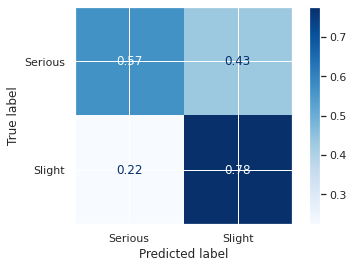

Random Forest with class weighting
              precision    recall  f1-score   support

     Serious       0.40      0.22      0.28       421
      Slight       0.87      0.94      0.90      2347

    accuracy                           0.83      2768
   macro avg       0.63      0.58      0.59      2768
weighted avg       0.80      0.83      0.81      2768



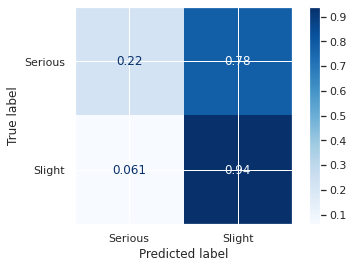

Balanced Random Forest
              precision    recall  f1-score   support

     Serious       0.28      0.73      0.40       421
      Slight       0.93      0.66      0.77      2347

    accuracy                           0.67      2768
   macro avg       0.61      0.70      0.59      2768
weighted avg       0.83      0.67      0.72      2768



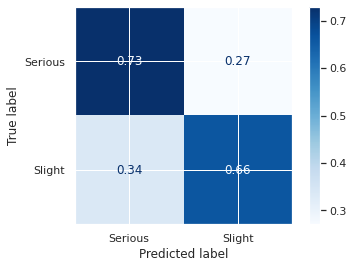

In [51]:
best_bagging = joblib.load("./pretrained/bagging.joblib")
best_rf_random = joblib.load("./pretrained/rf_classWeighting.joblib")
best_ib_rf = joblib.load("./pretrained/ib_rf.joblib")

classifiers = {'Balanced Bagging Classifier': best_bagging, 
               'Random Forest with class weighting': best_rf_random, 
               'Balanced Random Forest': best_ib_rf}
for classifier in classifiers.keys():
    print(classifier)
    evaluate(classifiers[classifier], X_test, y_test, list(y_test.value_counts().index))
    print('============================================================')